# Toy Neural Net (Multilayer Perceptron with Autograd Backpropogation)

Goal: Train a multilayer perceptron to recognize numbers from images using the MNIST database.

Made with help from:
- https://nextjournal.com/gkoehler/pytorch-mnist
- https://github.com/WatChMaL/ExampleNotebooks/blob/master/MNIST%20MLP.ipynb

# Loading the MNIST database

Initializing a trainLoader and testLoader for training and evaluation:

In [28]:
import numpy as np
import torch
import torch.nn as nn
import torchvision

# Set parameters for dataset to fetch
trainBatchSize = 20
testBatchSize = 1000

# Fetch datasets and build locally
dataset = torchvision.datasets.MNIST('.', train=True, download=True,
                                     transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()]))
trainLoader = torch.utils.data.DataLoader(dataset, batch_size=trainBatchSize, shuffle=True)
testLoader = torch.utils.data.DataLoader(dataset, batch_size=testBatchSize, shuffle=True)


# Fetch datasets (28x28 pixels) (does not work on ComputeCanada)
#trainLoader = torch.utils.data.DataLoader(
#  torchvision.datasets.MNIST('/files/', train=True, download=False,
#                             transform=torchvision.transforms.Compose([
#                               torchvision.transforms.ToTensor()])),
#  batch_size=trainBatchSize, shuffle=True)

#testLoader = torch.utils.data.DataLoader(
#  torchvision.datasets.MNIST('/files/', train=False, download=False,
#                             transform=torchvision.transforms.Compose([
#                               torchvision.transforms.ToTensor()])),
#  batch_size=testBatchSize, shuffle=True)

Plot some of the test data for fun:

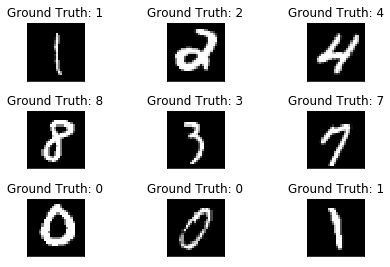

In [29]:
import matplotlib.pyplot as plt

examples = enumerate(testLoader)
idx, (exampleData, exampleTargets) = next(examples)

fig = plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(exampleData[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(exampleTargets[i]))
    plt.xticks([])
    plt.yticks([])

# MLP Implementation

Time to implement the neural net. Somewhat arbitrarily, I decided to use an MLP with 2 hidden layers of 500, then 100 neurons, with an input layer of 28x28 = 784 neurons and an output layer of 10 neurons corresponding to the digits.

In [30]:
class MLP(nn.Module):
    # Constructor initializes two hidden layers with neuron counts specified by the user
    def __init__(self, L1, L2):
        super(MLP, self).__init__()
        # input -(W1)-> L1 -(W2)-> L2 -(W3)-> output
        self._classifier = nn.Sequential(
            nn.Linear(28*28, L1), nn.ReLU(),
            nn.Linear(L1, L2), nn.ReLU(),
            nn.Linear(L2, 10)
        )
        
    def forward(self, x):
        # Flatten 2d input into 1d array:
        x_flat = x.view(-1, np.prod(x.size()[1:]))
        # Run through classifier
        return self._classifier(x_flat)

Next, define a BLOB class to organize training objects:

In [31]:
# Empty class definition
class BLOB:
    pass
# Dynamic attribute allocation
blob = BLOB()
blob.net = MLP(128, 128) # HERE SHE IS
blob.errFn = nn.CrossEntropyLoss() # Error-defining function is softmax
blob.optim = torch.optim.Adam(blob.net.parameters()) # Adam optimizer algorithm
blob.iter = 0 # training iteration number
blob.data = None # data for training/analysis
blob.expect = None # correct values

# Forward evolution function
# REQUIRES: blob arg must have all attributes set
def forward(blob, train=True):
    with torch.set_grad_enabled(train):
        # Get prediction from MLP
        pred = blob.net(blob.data)
        # Training stuff
        loss = -1
        if blob.expect is not None:
            # blob.expect.requires_grad(False) # Something odd is happening on this line, commenting it out seems to work
            loss = blob.errFn(pred, blob.expect)
        # Another dynamically assigned attribute
        blob.loss = loss
        
        pred = torch.argmax(pred, dim=1)
        correctTensor = (pred == blob.expect) # Tensor of booleans corresponding to correct predictions
        acc = correctTensor.sum().item() / float(pred.nelement()) # Accuracy of MLP
        
        return {'prediction' : pred.detach().numpy(),
                'loss'       : loss.detach().item(),
                'accuracy'   : acc}
    
# Backprop initialization
# REQUIRES: blob arg must first have been run through forward
def backward(blob):
    blob.optim.zero_grad()
    blob.loss.backward()
    blob.optim.step()

# Training

And now for the training:

In [32]:
# Set MLP to training mode
blob.net.train()
# Set number of training iterations
maxIter = 2000
# Set reporting interval
repIter = 10
# Training loop
for i, data in enumerate(trainLoader):
    blob.iter = i
    # data consists of a list of two tensors [img data, values]
    # unpack data into appropriate attributes in blob
    blob.data, blob.expect = data
    # test MLP
    res = forward(blob)
    # Report if current iteration is a multiple of the reporting interval
    if (blob.iter % repIter) == 0:
        print('Iteration:', blob.iter,'\t| Loss:', res['loss'],'\t| Accuracy:',res['accuracy'])
    if (blob.iter + 1 >= maxIter):
        break
    # Backprop
    backward(blob)

Iteration: 0 	| Loss: 2.2989249229431152 	| Accuracy: 0.1
Iteration: 10 	| Loss: 2.091398000717163 	| Accuracy: 0.45
Iteration: 20 	| Loss: 2.1019856929779053 	| Accuracy: 0.4
Iteration: 30 	| Loss: 1.6761448383331299 	| Accuracy: 0.35
Iteration: 40 	| Loss: 0.9298934936523438 	| Accuracy: 0.85
Iteration: 50 	| Loss: 0.757409393787384 	| Accuracy: 0.9
Iteration: 60 	| Loss: 0.7806510925292969 	| Accuracy: 0.7
Iteration: 70 	| Loss: 0.8691949844360352 	| Accuracy: 0.8
Iteration: 80 	| Loss: 0.7263573408126831 	| Accuracy: 0.85
Iteration: 90 	| Loss: 0.47780856490135193 	| Accuracy: 0.85
Iteration: 100 	| Loss: 0.437007337808609 	| Accuracy: 0.9
Iteration: 110 	| Loss: 0.3399107754230499 	| Accuracy: 0.9
Iteration: 120 	| Loss: 0.60759037733078 	| Accuracy: 0.85
Iteration: 130 	| Loss: 0.41110140085220337 	| Accuracy: 0.85
Iteration: 140 	| Loss: 0.36324018239974976 	| Accuracy: 0.95
Iteration: 150 	| Loss: 0.30307653546333313 	| Accuracy: 0.8
Iteration: 160 	| Loss: 0.40069514513015747 

Iteration: 1360 	| Loss: 0.03708387538790703 	| Accuracy: 1.0
Iteration: 1370 	| Loss: 0.07793104648590088 	| Accuracy: 1.0
Iteration: 1380 	| Loss: 0.5987817645072937 	| Accuracy: 0.8
Iteration: 1390 	| Loss: 0.10455223172903061 	| Accuracy: 0.95
Iteration: 1400 	| Loss: 0.6463900804519653 	| Accuracy: 0.85
Iteration: 1410 	| Loss: 0.3721548318862915 	| Accuracy: 0.9
Iteration: 1420 	| Loss: 0.05989720672369003 	| Accuracy: 1.0
Iteration: 1430 	| Loss: 0.13072408735752106 	| Accuracy: 1.0
Iteration: 1440 	| Loss: 0.12356019020080566 	| Accuracy: 0.95
Iteration: 1450 	| Loss: 0.09168006479740143 	| Accuracy: 0.95
Iteration: 1460 	| Loss: 0.2217995822429657 	| Accuracy: 0.9
Iteration: 1470 	| Loss: 0.28302714228630066 	| Accuracy: 0.9
Iteration: 1480 	| Loss: 0.02679530344903469 	| Accuracy: 1.0
Iteration: 1490 	| Loss: 0.25689223408699036 	| Accuracy: 0.95
Iteration: 1500 	| Loss: 0.09693864732980728 	| Accuracy: 0.95
Iteration: 1510 	| Loss: 0.0887162834405899 	| Accuracy: 1.0
Iterati

# Evaluation

Now to test the MLP on data it hasn't seen before:

In [33]:
def evaluate(blob, loader):
    # Set MLP to evalutation mode
    blob.net.eval()
    # Initialize result containers
    accuracy, expected, prediction = [], [], []
    for i, data in enumerate(loader):
        blob.data, blob.expect = data
        res = forward(blob)
        accuracy.append(res['accuracy'])
        prediction.append(res['prediction'])
        expected.append(blob.expect)
    # Organize result arrays
    accuracy = np.hstack(accuracy)
    expected = np.hstack(expected)
    prediction = np.hstack(prediction)
    return accuracy, expected, prediction

# For the training set:
accuracy, label, prediction = evaluate(blob, trainLoader)
print("TRAIN\taccuracy mean",accuracy.mean(),"std",accuracy.std())

# For the testing set:
accuracy, label, prediction = evaluate(blob, testLoader)
print("TEST\taccuracy mean",accuracy.mean(),"std",accuracy.std())

TRAIN	accuracy mean 0.9598166666666667 std 0.04435988866332086
TEST	accuracy mean 0.9598166666666667 std 0.005937147650363958


YAY! My first real neural net!